Q1. In homework 1, we have built a deep feedforward neural network with two hidden layers and implemented the stochastic gradient decent (SGD) algorithm to train the network. Based on your codes, replace the ‘sigmoid’ activation functions with ‘relu’ and retrain the model. Compare the results with those in homework 1 (Question 2).

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [202]:
# Activation functions
def drelu(z):
    """
    Derivate of RELU
    """
    return np.ones((z.shape[0], z.shape[1]))*np.greater(z, 0)
    
def relu(z):
    return np.maximum(0, z)
    
def sigmoid(z):
  return 1 / (1 + np.exp(-1*z))

def softmax(z):
    return (np.exp(z) / np.sum(np.exp(z)))

In [215]:
# Helper function to predict an output (0 or 1) and compute accuracy
def predict(model, x, dropout=False, pdrop=(1/3), droput=False):
    W1, W2, W3 = model['W1'], model['W2'], model['W3']
    if dropout:
        W1 = W1*(1-pdrop)
        W2 = W2*(1-pdrop)
        W3 = W3*(1-pdrop)
        
    confusion_matrix=[[0,0],[0,0]]
    # Testing the model
    accuracy = 0
    for i, X in enumerate(test_data, 0):
        X = np.reshape(X, (1, 2))
        y = np.reshape(test_labels[i, :], (1,2))
        z1 = X.dot(W1)
        a1 = sigmoid(z1)
        z2 = a1.dot(W2)
        if dropout:
            z2 = z2*(1-pdrop)
        a2 = sigmoid(z2)
        z3 = a2.dot(W3)
        exp_scores = np.exp(z3)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        idx = np.argmax(probs, axis=1)
        accuracy+=y[0, idx]
        
        ix = idx.astype(bool)
        l = y[0].astype(bool)
        
        if l[0]:
            if not ix[0]:
                confusion_matrix[0][0] +=1
            else:
                confusion_matrix[0][1] +=1
        elif l[1]:
            if ix[0]:
                confusion_matrix[1][1] +=1
            else:
                confusion_matrix[1][0]+=1

    return confusion_matrix, (accuracy/test_data.shape[0]*100)


In [204]:
# This function learns parameters for the neural network and returns the model.
def build_model(train_data, labels, input_dim, hidden_dim, output_dim, epochs=1):
    """
    train_data: training data
    labels: training data labels in one-hot vector format
    input_dim: 2 in our case
    hidden_dim: 3 in our case
    output_dim: 2 in our case
    epochs: no. of passes through the training data
    """
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    W2 = np.random.randn(hidden_dim, hidden_dim) / np.sqrt(hidden_dim)
    W3 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for epoch in range(0, epochs):
        print("Training for epoch: {}".format(epoch+1))
        for i, X in enumerate(train_data):

            # Forward propagation
            X = np.reshape(X, (1, 2))
            y = np.reshape(labels[i, :], (1,2))
            z1 = X.dot(W1)

            a1 = relu(z1)
            z2 = a1.dot(W2)

            a2 = relu(z2)
            z3 = a2.dot(W3)

            # softmax
            exp_scores = np.exp(z3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            ones = np.ones(exp_scores.shape)

            # loss for one example             
            loss = np.sum((y-exp_scores)*(y-exp_scores))
#             print('Training loss: {}'.format(loss))
            
            # derivate of softmax w.r.t its inputs z3
            dsoftmax = ones*(np.prod(exp_scores)/(np.sum(exp_scores)*np.sum(exp_scores)))

            # Backpropogation
            dy = dsoftmax*2*(probs-y)
            delta3 = drelu(z2)*dy.dot(W3.T)
            delta2 = drelu(z1)*delta3.dot(W2.T)


            # gradients of Loss w.r.t model parameters             
            dW3 = (a2.T).dot(dy)
            dW2 = (a1.T).dot(delta3)
            dW1 = np.dot(X.T, delta2)

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            W2 += -epsilon * dW2
            W3+= -epsilon * dW3

    model = { 'W1': W1, 'W2': W2, 'W3': W3}
    return model

In [205]:
def process_labels(data):
    labels = np.ndarray((data.shape[0], 2), dtype=float)
    for i,label in enumerate(data.iloc[:, 2]):
        if label == 1:
            labels[i,0] = 0
            labels[i,1] = 1
        elif label == 0:
            labels[i,0] = 1
            labels[i,1] = 0
    return labels

In [208]:
train_data = pd.read_csv('train_data.txt') # note remove spaces around the header column in train_data.txt and test_data.txt
train_data = train_data.sample(frac=1) # shuffle the training examples
train_labels = process_labels(train_data)
train_data.drop(['class'], axis = 1, inplace = True)
train_data = train_data.values

num_examples = len(train_data) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

epsilon = 0.1 # learning rate for gradient descent


# Build a model with a 3-dimensional hidden layer
model = build_model(train_data, train_labels,  2, 3, 2, epochs=1)

# read test data
test_data = pd.read_csv('test_data.txt')
test_data = test_data.sample(frac=1)
test_labels = process_labels(test_data)
test_data.drop(['class'], axis = 1, inplace = True)
test_data = test_data.values


confusion_matrix_1, accuracy = predict(model, test_data)
# Test model
# printing test accuracy
print("Confusion Matrix: {}".format(confusion_matrix_1))
print("Test accuracy: {}%".format(accuracy[0]))

Training for epoch: 1
Confusion Matrix: [[500, 0], [1, 499]]
Test accuracy: 99.9%


The accuracy doesn't seem to change

Q1.b Suppose the dropout rate of neurons for layer 2 is 1/3, which means only two out of three neurons will be kept during the training for each batch, where the batch size is 1. Implement the backpropagation and train the network. Show the performance on the Test Data.


In [ ]:
pdropout = 1/3

In [210]:
# This function learns parameters for the neural network and returns the model.
def build_model_dropout(train_data, labels, input_dim, hidden_dim, output_dim, epochs=3, pdrop=(1/3)):
    """
    train_data: training data
    labels: training data labels in one-hot vector format
    input_dim: 2 in our case
    hidden_dim: 3 in our case
    output_dim: 2 in our case
    epochs: no. of passes through the training data
    """
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    W2 = np.random.randn(hidden_dim, hidden_dim) / np.sqrt(hidden_dim)
    W3 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for epoch in range(0, epochs):
        loss = 0
        print("Training for epoch: {}".format(epoch+1))
        for i, X in enumerate(train_data):

            # Forward propagation
            X = np.reshape(X, (1, 2))
            y = np.reshape(labels[i, :], (1,2))
            z1 = X.dot(W1)
#             a1 = sigmoid(z1)
            a1 = relu(z1)
            z2 = a1.dot(W2)
            a2 = sigmoid(z2)
            
            # keep neurons with probability 1-pdrop        
            a2 = a2*np.random.binomial([np.ones((len(a2),hidden_dim))],1-pdrop)[0]
        
            a2 = relu(z2)
            z3 = a2.dot(W3)

            # softmax
            exp_scores = np.exp(z3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            ones = np.ones(exp_scores.shape)

            # loss for one example  
            loss += np.sum((exp_scores-y)*(exp_scores-y))
            
            
            # derivate of softmax w.r.t its inputs z3
            dsoftmax = ones*(np.prod(exp_scores)/(np.sum(exp_scores)*np.sum(exp_scores)))

            # Backpropogation
            dy = dsoftmax*2*(probs-y)
            delta3 = drelu(z2)*dy.dot(W3.T)
            delta2 = drelu(z1)*delta3.dot(W2.T)
#             delta3 = sigmoid(z2)*(1-sigmoid(z2))*dy.dot(W3.T)
#             delta2 = sigmoid(z1)*(1-sigmoid(z1))*delta3.dot(W2.T)

            # gradients of Loss w.r.t model parameters             
            dW3 = (a2.T).dot(dy)
            dW2 = (a1.T).dot(delta3)
            dW1 = np.dot(X.T, delta2)

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            W2 += -epsilon * dW2
            W3+= -epsilon * dW3

        print('loss for epoch {}: {}'.format(epoch, loss))
    model = { 'W1': W1, 'W2': W2, 'W3': W3}
    return model



In [220]:
# Build a model using droput probability pdrop
model = build_model_dropout(train_data, train_labels,  2, 3, 2, epochs=2, pdrop=(1/3))

confusion_matrix_1, accuracy = predict(model, test_data, dropout=True)
# Test model
# printing test accuracy
print("Confusion Matrix: {}".format(confusion_matrix_1))
print("Test accuracy: {}%".format(accuracy[0]))

Training for epoch: 1
loss for epoch 0: 4646906099560906.0
Training for epoch: 2
loss for epoch 1: 1.3029933788151919e+19
Confusion Matrix: [[497, 3], [0, 500]]
Test accuracy: 99.7%


After using droput the test accuracy seems to decrease a little bit

### Q3. RNN

In [2]:
# PREPROCESS
def idx_to_word(words_to_idx):
    idx_to_words = {}
    for word, idx in words_to_idx:
        idx_to_words[idx] = word
    
    return idx_to_words
    
    
def word_to_idx(words):
    words_to_idx = {}
    for i, word in enumerate(words):
        words_to_idx[word] = i
    
    return words_to_idx

In [3]:
maxSeqLength = 100
numDimensions = 50
trd = pd.read_csv('sentiment-data/train.csv', header=None)
ted = pd.read_csv('sentiment-data/test.csv', header=None)
numTrainExamples = trd.shape[0]
numTestExamples  = ted.shape[0]

In [4]:
wvfile = pd.read_csv('word-vectors-refine.txt', header=None)
wordVectors = wvfile[wvfile.columns.difference([0])].values

In [5]:
words = wvfile[0].values
wordsList = words.tolist()

In [6]:
idsMatrix = np.zeros((numTrainExamples, maxSeqLength), dtype=int)

In [7]:
words_to_id = word_to_idx(wordsList)

In [8]:
for c, review in trd.iterrows():
    for i, word in enumerate(review[1].split(' ')):
        try:
            idsMatrix[c][i] = words_to_id[word]
        except KeyError as e:
            idsMatrix[c][i] = 399999 #Vector for unkown words

In [9]:
idsMatrixTest = np.zeros((ted.shape[0], maxSeqLength), dtype=int)
for c, review in ted.iterrows():
    for i, word in enumerate(review[1].split(' ')):
        try:
            idsMatrixTest[c][i] = words_to_id[word]
        except KeyError as e:
            idsMatrixTest[c][i] = 399999 #Vector for unkown words

In [10]:
# Helper functions
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(1,20000)
        if trd.iloc[num, 0] == 'positive':
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = idsMatrix[num-1:num]
    return arr, labels

def getTestBatch(batch_size=24):
    """
    Returns the entire training data
    """
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if ted.iloc[i, 0] == 'positive':
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = idsMatrixTest[i]
    return arr, labels

In [11]:
# some constants
batchSize = 24
lstmUnits = 64
rnnUnits = 64
gruUnits = 64
numClasses = 2
iterations = 50

In [12]:
# tf.reset_default_graph()
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [13]:
# Uncomment the appropriate code for lstm, rnn and gru cells respectively

# lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
# lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
# value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float64)

# rnnCell = tf.contrib.rnn.BasicRNNCell(rnnUnits)
# rnnCell = tf.contrib.rnn.DropoutWrapper(cell=rnnCell, output_keep_prob=0.75)
# value, _ = tf.nn.dynamic_rnn(rnnCell, data, dtype=tf.float64)

gruCell = tf.contrib.rnn.GRUCell(gruUnits)
gruCell = tf.contrib.rnn.DropoutWrapper(cell=gruCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(gruCell, data, dtype=tf.float64)

In [14]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(tf.cast(last, tf.float32), weight) + bias)

In [15]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for i in range(iterations):
       #Next Batch of reviews
        nextBatch, nextBatchLabels = getTrainBatch()
        if i%10==0:
            train_accuracy = accuracy.eval(feed_dict={input_data: nextBatch, labels: nextBatchLabels})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            print('step %d, training loss %g' % (i, 
                loss.eval(feed_dict={input_data: nextBatch, labels: nextBatchLabels})))
        optimizer.run(feed_dict={input_data: nextBatch, labels: nextBatchLabels})
           
    testBatch, testLabels = getTestBatch(batch_size=5000)
    print('test accuracy %g' % accuracy.eval(feed_dict={input_data: testBatch, labels: testLabels}))
    

step 0, training accuracy 0.333333
step 0, training loss 2.49366
step 10, training accuracy 1
step 10, training loss 0.00174457
step 20, training accuracy 1
step 20, training loss 0.000111203
step 30, training accuracy 1
step 30, training loss 3.41636e-05
step 40, training accuracy 1
step 40, training loss 0.000479253
test accuracy 1


## Q2 . CNN

In [26]:
# MNIST dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [27]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [2]:
# utility functions to create weight variables
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [3]:
# define convolution and max pooling operations
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='VALID')

In [10]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [11]:
# conv1 layer 3x3 stride=1, padding=None, input channels=1, output channels=32
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])

# reshape the image
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# pool 1
h_pool1 = max_pool_2x2(h_conv1)

In [12]:
# conv2 layer 5x5, stride=1, padding=None, input channels = 32, output channels=64
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2)+ b_conv2)

# pool 2
h_pool2 = max_pool_2x2(h_conv2)

In [13]:
# FC layer with 1024 neurons
W_fc1 = weight_variable([4 * 4 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [14]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [1]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

NameError: name 'weight_variable' is not defined

In [16]:
def train_model():
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_label = tf.argmax(y_, 1)
    prediction = tf.argmax(y_conv, 1)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # create arrays for visualizing images
    images = np.zeros((9, 784))
    labels = np.zeros((9,2))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(1):
            batch = mnist.train.next_batch(50)
            if i % 10 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %g' % (i, train_accuracy))
            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

        print('test accuracy %g' % accuracy.eval(feed_dict={
          x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
        
        
        for i in range(9):
            image, label = mnist.test.next_batch(1)
            images[i] = image
        # get correct predictions and correct labels for 9 MNIST images
            labels[i][0] = prediction.eval( {x: image, y_: label, keep_prob: 1.0})
            labels[i][1] = correct_label.eval( {x: image, y_: label, keep_prob: 1.0})
            
    return images, labels

Accuracies of MNIST when trained for 20000 iterations

In [79]:
images, labels = train_model()

step 0, training accuracy 0.1
test accuracy 0.0744


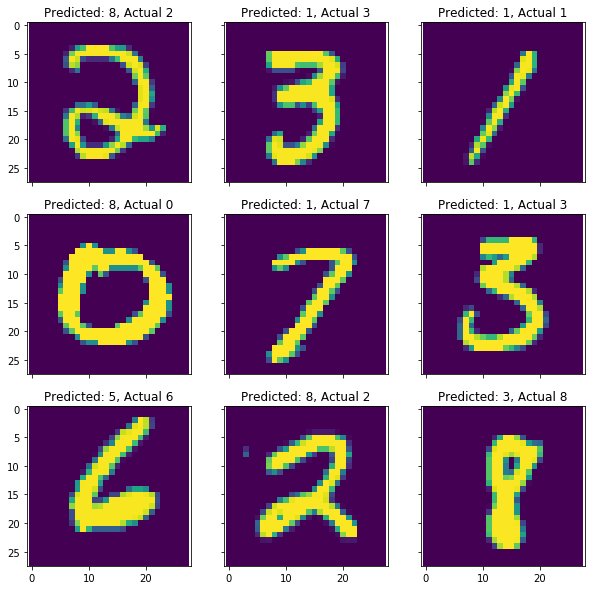

In [85]:
# Visualizing MNIST images and predicted and correct labels
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
k=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(np.reshape(images[k], (28, 28)))
        axs[i,j].set_title('Predicted: {}, Actual {}'.format(int(labels[k][0]), int(labels[k][1])))
        k+=1

plt.show()

### Train on CIFAR100

In [4]:
from tensorflow.contrib.keras.python.keras.datasets import cifar100
train, test = cifar100.load_data(label_mode='fine')
train_X, train_Y = train[0], train[1]
test_X, test_Y = test[0], test[1]

In [5]:
train_X = np.reshape(train_X, (train_X.shape[0], 32*32, 3))
test_X = np.reshape(test_X, (test_X.shape[0], 32*32, 3))

In [6]:
# convert test labels to one-hot vectors
train_Y = np.eye(100)[train_Y]
train_Y = np.reshape(train_Y, (train_Y.shape[0], 100))

test_Y = np.eye(100)[test_Y]
test_Y = np.reshape(test_Y, (test_Y.shape[0], 100))


i = np.random.randint(0, 10000)
viz_image = test_X[i]
viz_label = test_Y[i]

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 1024, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 100])

# conv1 layer 3x3 stride=1, padding=None, input channels=3, output channels=32
W_conv1 = weight_variable([3, 3, 3, 32])
b_conv1 = bias_variable([32])

# reshape the image
x_image = tf.reshape(x, [-1, 32, 32, 3])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# pool 1
h_pool1 = max_pool_2x2(h_conv1)

# conv2 layer 5x5, stride=1, padding=None, input channels = 32, output channels=64
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2)+ b_conv2)

# pool 2
h_pool2 = max_pool_2x2(h_conv2)

In [8]:
h_pool2.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(64)])

In [9]:
# FC layer with 1024 neurons
W_fc1 = weight_variable([5 * 5 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 5*5*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 100])
b_fc2 = bias_variable([100])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [10]:
def minibatch(data, labels, minibatch_idx):
    return data[minibatch_idx], labels[minibatch_idx]

def get_next_batch(data, labels, minibatch_size=50):
    data_size = len(data)
    indices = np.arange(data_size)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield minibatch(data, labels, minibatch_indices)

        

In [18]:
def train_cifar100():
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    correct_label = tf.argmax(y_, 1)
    prediction = tf.argmax(y_conv, 1)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(20):
            for batch, labels in get_next_batch(train_X, train_Y, minibatch_size=250):
                train_step.run(feed_dict={x: batch, y_: labels, keep_prob: 0.5})
            train_accuracy = accuracy.eval(feed_dict={x: batch, y_: labels, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))

        print('test accuracy %g' % accuracy.eval(feed_dict={x: test_X, y_: test_Y, keep_prob: 1.0}))
        
        #  hconv1, hconv2 feature maps of first and second convolutional layers       
        hconv1 = h_conv1.eval(feed_dict = { x: np.reshape(viz_image, (1, 1024, 3)), y_: np.reshape(viz_label, (1, 100)), keep_prob: 1.0})
        hconv2 = h_conv2.eval(feed_dict = { x: np.reshape(viz_image, (1, 1024, 3)), y_: np.reshape(viz_label, (1, 100)), keep_prob: 1.0})
                
        # Get 9 images and their correct and predicted labels for visualization
        images = np.zeros((9, 32*32, 3))
        predictions = np.zeros((9))
        correct_labels = np.zeros((9))

        
        for im, label in get_next_batch(test_X, test_Y, minibatch_size=9):
            predictions = np.reshape(prediction.eval( {x: im, y_: label, keep_prob: 1.0}), (9,1))
            correct_labels = np.reshape(correct_label.eval( {x: im, y_: label, keep_prob: 1.0}), (9,1))
            break;
        
    return hconv1, hcdrivonv2, im, predictions, correct_labels

In [19]:
hconv1, hconv2, im, predictions, correct_labels = train_cifar100()

step 0, training accuracy 0.004
step 1, training accuracy 0.004
step 2, training accuracy 0.004
step 3, training accuracy 0.012
step 4, training accuracy 0.008
step 5, training accuracy 0.012
step 6, training accuracy 0.008
step 7, training accuracy 0.012
step 8, training accuracy 0.008
step 9, training accuracy 0.004
step 10, training accuracy 0.016
step 11, training accuracy 0.012
step 12, training accuracy 0.016
step 13, training accuracy 0.012
step 14, training accuracy 0.02
step 15, training accuracy 0.012
step 16, training accuracy 0.012
step 17, training accuracy 0.016
step 18, training accuracy 0.02
step 19, training accuracy 0.028
test accuracy 0.0112


I tried with different learning rates,0.01, 0.0001 and  0.001. 0.001 seemed to perform the best. I did not have enough computational resources to train on CIFAR100 or MNIST on more number of iterations. Clearly accuracy is improving for more iterations.

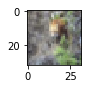

In [22]:
# Image used for visualization
plt.figure(figsize=(1,1))
plt.imshow(np.reshape(viz_image, (32, 32, 3)))
plt.show()

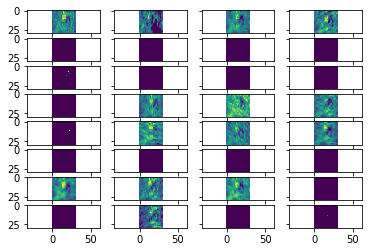

In [23]:
# Visualizing CIFAR100 feature maps
fig, axs = plt.subplots(8, 4, sharex=True, sharey=True)
k=0
for i in range(8):
    for j in range(4):
        axs[i,j].imshow(hconv1[0,:,:,k])
        k+=1

plt.show()

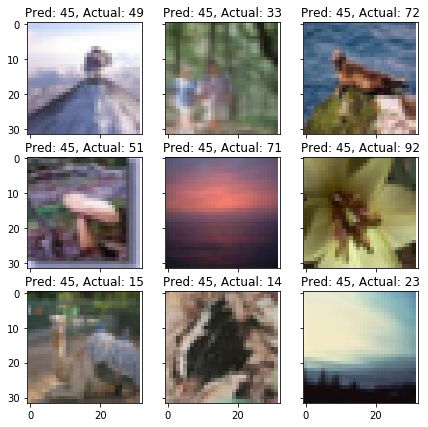

In [28]:
# Visualizing Cifar100 images and predicted and correct labels
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(7,7))
k=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(np.reshape(im[k], (32, 32, 3)))
        axs[i,j].set_title('Pred: {}, Actual: {}'.format(int(predictions[k]), int(correct_labels[k])))
        k+=1

plt.show()